<a href="https://colab.research.google.com/github/Ni7070/NumtaDbBanglaDigitRecognizer/blob/main/NumtaDB_Bangla_Digit_Recognizer_with_Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import path
import shutil
import glob

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tahiranishat","key":"8ed924ff655cd5b32f597aa3e24be0fa"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.90G/1.91G [00:18<00:00, 41.1MB/s]
100% 1.91G/1.91G [00:18<00:00, 111MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = "numta.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done!")

Done!


In [ ]:
#read CSV files only filename and digit column
trainA =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainB =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainC =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainD =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])
trainE =pd.read_csv('/content/training-a.csv', usecols = ['filename', 'digit'])

In [ ]:
print(trainA.columns)
print(trainB.columns)
print(trainC.columns)
print(trainD.columns)
print(trainE.columns)

Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')


In [ ]:
merged_csv = pd.concat(([trainA, trainB, trainC, trainD, trainE]))
print(len(merged_csv))
print(merged_csv.tail())

In [ ]:
TRAIN_PATH = "trainAllNumtadb"
PATH = '/content/'

In [ ]:
os.mkdir(TRAIN_PATH)

In [ ]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)

In [ ]:
processImages('training-a')
print('A Done')
processImages('training-b')
print('B Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')
processImages('training-e')
print('E Done')

A Done
B Done
C Done
D Done
E Done


In [ ]:
class numtaDb(Dataset):
    def __init__(self, merged_csv_file, root_dir, transform=None):
        self.data = merged_csv_file
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        path = self.root_dir + '/' + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])
'''
LOADING DATASET
'''
dataset = numtaDb(merged_csv_file = merged_csv, root_dir = TRAIN_PATH, 
                            #train=True, 
                            transform = dset_transform # Normalize the image to [0-1] from [0-255]
                            )


In [ ]:
#split data into train:test = 90:10
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1)

###Settings: 01

In [ ]:
# Hyperparameters for settings 1 accuracy 79.72794640138056%
batch_size = 260
num_iters = 30000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10

learning_rate = 0.004

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer:
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.tanh = nn.Tanh()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_1 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_2 = nn.ReLU6()

        ### 5th hidden layer: 
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.tanh(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_1(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_2(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        #print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            

Iteration: 500. Loss: 2.173247814178467. Accuracy: 17.754542686021722
Iteration: 1000. Loss: 2.1375913619995117. Accuracy: 31.042533752918484
Iteration: 1500. Loss: 2.01997709274292. Accuracy: 44.66551619124962
Iteration: 2000. Loss: 2.0406312942504883. Accuracy: 45.57912902243427
Iteration: 2500. Loss: 2.0415892601013184. Accuracy: 39.81321693229114
Iteration: 3000. Loss: 1.9293484687805176. Accuracy: 51.6191249619328
Iteration: 3500. Loss: 1.961769700050354. Accuracy: 48.1067911887118
Iteration: 4000. Loss: 1.8616180419921875. Accuracy: 52.22820018272257
Iteration: 4500. Loss: 1.8904502391815186. Accuracy: 53.47680438534159
Iteration: 5000. Loss: 1.8847837448120117. Accuracy: 61.88204243224038
Iteration: 5500. Loss: 1.8262001276016235. Accuracy: 52.55304030047711
Iteration: 6000. Loss: 1.8977068662643433. Accuracy: 58.34940615165973
Iteration: 6500. Loss: 1.7972173690795898. Accuracy: 66.73434169119886
Iteration: 7000. Loss: 1.7933120727539062. Accuracy: 68.43975230941021
Iteration: 

Settings: 02

In [ ]:
# Hyperparameters for settings 2 accuracy 89.55435996345548%
batch_size = 250
num_iters = 15000
input_dim = 28*28 # num_features = 784
num_hidden = 180
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.ReLU6()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        # print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2256956100463867. Accuracy: 23.134707136331336
Iteration: 1000. Loss: 2.121375799179077. Accuracy: 30.94102121612019
Iteration: 1500. Loss: 2.0070903301239014. Accuracy: 47.081514567049034
Iteration: 2000. Loss: 1.9823884963989258. Accuracy: 48.78692518526038
Iteration: 2500. Loss: 1.8491005897521973. Accuracy: 59.963455486752615
Iteration: 3000. Loss: 1.84553861618042. Accuracy: 61.52674855344635
Iteration: 3500. Loss: 1.847179651260376. Accuracy: 64.20667952492133
Iteration: 4000. Loss: 1.7664850950241089. Accuracy: 68.95746624708151
Iteration: 4500. Loss: 1.7670466899871826. Accuracy: 70.3684905085778
Iteration: 5000. Loss: 1.747267246246338. Accuracy: 70.1248604202619
Iteration: 5500. Loss: 1.7450129985809326. Accuracy: 75.99228504720332
Iteration: 6000. Loss: 1.7230989933013916. Accuracy: 74.70307582986499
Iteration: 6500. Loss: 1.6675074100494385. Accuracy: 78.00223327580956
Iteration: 7000. Loss: 1.6458797454833984. Accuracy: 78.11389706628769
Iteration: 

[2.2256956100463867, 2.121375799179077, 2.0070903301239014, 1.9823884963989258, 1.8491005897521973, 1.84553861618042, 1.847179651260376, 1.7664850950241089, 1.7670466899871826, 1.747267246246338, 1.7450129985809326, 1.7230989933013916, 1.6675074100494385, 1.6458797454833984, 1.6626840829849243, 1.6307342052459717, 1.6497786045074463, 1.6599210500717163, 1.6261565685272217, 1.6507707834243774, 1.6209516525268555, 1.6119846105575562, 1.5893127918243408, 1.63542640209198, 1.6157313585281372, 1.6497554779052734, 1.5578114986419678, 1.5587546825408936, 1.6006120443344116]


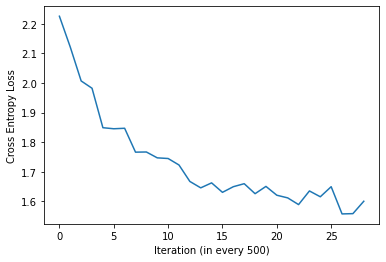

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

Settings: 03

In [ ]:
# Hyperparameters for settings3 accuracy = 95.7973809765506%
batch_size = 256
num_iters = 30000
input_dim = 28*28 # num_features = 784
num_hidden = 180
output_dim = 10

learning_rate = 0.002

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.ReLU6()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        # print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.186065673828125. Accuracy: 24.42391635366968
Iteration: 1000. Loss: 2.0563294887542725. Accuracy: 47.416505938483404
Iteration: 1500. Loss: 1.9219483137130737. Accuracy: 56.319155415693835
Iteration: 2000. Loss: 1.8299345970153809. Accuracy: 63.83108313876764
Iteration: 2500. Loss: 1.785597562789917. Accuracy: 69.68835651202923
Iteration: 3000. Loss: 1.6933268308639526. Accuracy: 65.21165363922445
Iteration: 3500. Loss: 1.7250250577926636. Accuracy: 76.73332656583088
Iteration: 4000. Loss: 1.9384100437164307. Accuracy: 77.65709065069537
Iteration: 4500. Loss: 1.643325686454773. Accuracy: 77.45406557709877
Iteration: 5000. Loss: 1.6825010776519775. Accuracy: 77.50482184549791
Iteration: 5500. Loss: 1.6641526222229004. Accuracy: 78.59100598923968
Iteration: 6000. Loss: 1.651277780532837. Accuracy: 73.4341691198863
Iteration: 6500. Loss: 1.618160367012024. Accuracy: 84.0422292153081
Iteration: 7000. Loss: 1.6142371892929077. Accuracy: 82.29621358237742
Iteration: 7

[2.186065673828125, 2.0563294887542725, 1.9219483137130737, 1.8299345970153809, 1.785597562789917, 1.6933268308639526, 1.7250250577926636, 1.9384100437164307, 1.643325686454773, 1.6825010776519775, 1.6641526222229004, 1.651277780532837, 1.618160367012024, 1.6142371892929077, 1.706053614616394, 1.638246774673462, 1.6090679168701172, 1.5710457563400269, 1.5673682689666748, 1.579543113708496, 1.5561658143997192, 1.5916247367858887, 1.5990298986434937, 1.601209282875061, 1.567156195640564, 1.5644041299819946, 1.5257506370544434, 1.5563956499099731, 1.597677230834961, 1.586694598197937, 1.5385777950286865, 1.6008617877960205, 1.553553581237793, 1.5245442390441895, 1.545431137084961, 1.5543407201766968, 1.5115690231323242, 1.5566765069961548, 1.544785737991333, 1.5655337572097778, 1.4907422065734863, 1.5244852304458618, 1.5280452966690063, 1.5305982828140259, 1.53854238986969, 1.5404118299484253, 1.497933030128479, 1.5149545669555664, 1.477828025817871, 1.5204428434371948, 1.5152225494384766

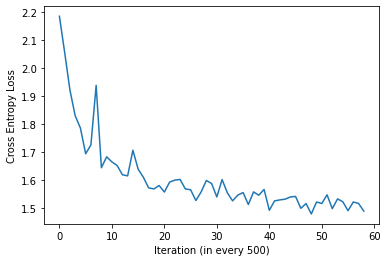

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

Settings: 04

In [ ]:
# Hyperparameters for settings4 with accuracy 97.95959801035428% 

batch_size = 256
num_iters = 54500
input_dim = 28*28 # num_features = 784
num_hidden = 180
output_dim = 10

learning_rate = 0.003

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer:
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.ReLU6()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        # print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.201491117477417. Accuracy: 29.560450715663386
Iteration: 1000. Loss: 2.0513815879821777. Accuracy: 44.949751294284845
Iteration: 1500. Loss: 1.8369840383529663. Accuracy: 53.39559435590295
Iteration: 2000. Loss: 1.8131026029586792. Accuracy: 64.72439346259263
Iteration: 2500. Loss: 1.7406741380691528. Accuracy: 74.51020200994823
Iteration: 3000. Loss: 1.7462730407714844. Accuracy: 72.54085879606131
Iteration: 3500. Loss: 1.7564940452575684. Accuracy: 73.74885798396102
Iteration: 4000. Loss: 1.7221499681472778. Accuracy: 75.6369911684093
Iteration: 4500. Loss: 1.6758028268814087. Accuracy: 78.4285859303624
Iteration: 5000. Loss: 1.6618329286575317. Accuracy: 81.43335701959192
Iteration: 5500. Loss: 1.6920701265335083. Accuracy: 79.75840016242006
Iteration: 6000. Loss: 1.6672130823135376. Accuracy: 75.76895746624709
Iteration: 6500. Loss: 1.6452836990356445. Accuracy: 83.20982641356207
Iteration: 7000. Loss: 1.6456049680709839. Accuracy: 86.05217744391432
Iteratio

[2.201491117477417, 2.0513815879821777, 1.8369840383529663, 1.8131026029586792, 1.7406741380691528, 1.7462730407714844, 1.7564940452575684, 1.7221499681472778, 1.6758028268814087, 1.6618329286575317, 1.6920701265335083, 1.6672130823135376, 1.6452836990356445, 1.6456049680709839, 1.6016525030136108, 1.6097795963287354, 1.542249083518982, 1.5717772245407104, 1.6124236583709717, 1.5843349695205688, 1.565311074256897, 1.5869605541229248, 1.565271258354187, 1.6233842372894287, 1.5791795253753662, 1.6019092798233032, 1.534839153289795, 1.5401586294174194, 1.521513819694519, 1.5856852531433105, 1.5359596014022827, 1.5412957668304443, 1.5724880695343018, 1.5365208387374878, 1.543574333190918, 1.6027129888534546, 1.505581259727478, 1.7152312994003296, 1.551384449005127, 1.5696102380752563, 1.521041750907898, 1.5205532312393188, 1.552426815032959, 1.54439377784729, 1.5259109735488892, 1.5170336961746216, 1.5491398572921753, 1.513755202293396, 1.4977127313613892, 1.505728840827942, 1.489639520645

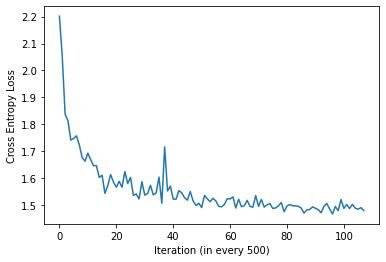

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
root_path = '/content'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'NumtaDb_deep18.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'NumtaDb_deep18.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


# **ID: 16.02.04.070**
# **Assignment #2**
# **Problem #1**
I have tried with many settings, tried how many layer is going to give a sustaining result where the cross entropy loss curve will decrease in a slow pace. I found that 4layer deep neueal network helped me to get nearer to a desired result. My result was getting better when I feed the neural network a bigger chunk at a time with a relatively lower learning rate passed it in a dimension which in nearer the the output dimension. I have found that doing so, my model was getting higher accuracy as the iteration increased  and the cross entropy loss was getting smallar with further iteration. But for this Assignment i have chosen my best 4 settings that I have tried with. Here is a brief description of that.

- **1st Settings:**
Used a 5 layer settings in a order like (tanh->leakyReLU->ReLU6->ReLU6->Sigmoid) with Adagrad optimizer accuracy was nearly 80%.
- **2nd Settings:**
Changed the previous settings. Used a 4 layer settings in a order like (leakyReLU->ReLU6->ReLU6->Sigmoid) with Adamax optimizer accuracy was nearly 89%. It was a great turn. As I saw the cross entropy loss curve, it was still declining, so i increased iteration and learning rate.
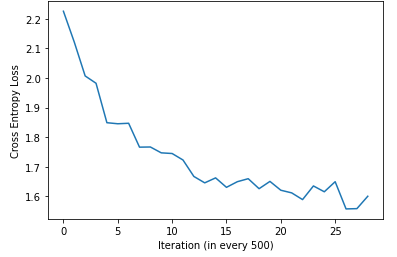
- **3rd Settings:**
After increasing iteration to 30000, accuracy went over 95% and the curve still looked pleasent.
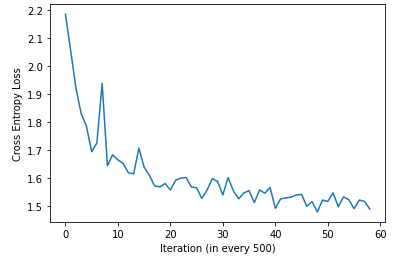
- **4th Settings:**
Then I increased iteration number to get a nice steady accuracy. After a little bit trying I have found the accuracy to be 97.95% stable at 54500 iteration. If I increase or decrease it a little bit, they result would flactuate. So, I decided to keep it as my final accuracy.
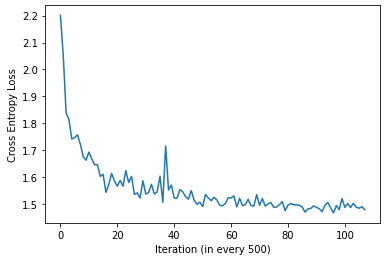


No.|batch_size | num_iters | learning rate|optimizer|hidden layer Dim|Accuracy
---|---|---|---|---|---|---|
1|260|30,000|0.004|Adagrad|200|79.72794640138056%
2|250|15,000|0.001|Adamax|180|89.55435996345548%
3|256|30,000|0.002|Adamax|180|95.7973809765506%
4|256|54500|0.003|Adamax|180|97.95959801035428%